# MNIST GAN

_A generative adversarial network (GAN) trained on the MNIST dataset to generate new images of handwritten digits._

## Imports and setup

In [7]:
import tensorflow as tf

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

## Load and prepare the MNIST dataset

The MNIST dataset is included in the keras library. This section can be replaced to generate images based on other training data.

In [3]:
# Load dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
# Convert to desired type and shape
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [5]:
# Set hyperparameters
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [6]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

A GAN consists of two neural networks: the **generator** and the **discriminator**.

### The Generator

This model generates images, starting from random noise as an input. It uses transpose convolutional layers, which are effectively convolutional layers but in reverse.

In [8]:
# Build the generator model

def make_generator_model():
    """This function builds the generator model.

    Returns:
        model: a keras sequential model
    """     
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

When untrained, the generator just produces random noise.

c:\Users\danie\OneDrive\Documents\Python Scripts\GAN-cats\.conda\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


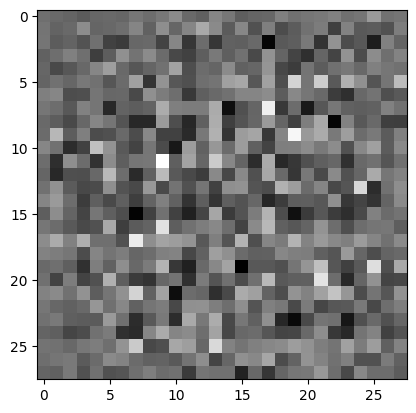

In [9]:
# Generate image

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator classifies images as either real or generated. It is a CNN model.

In [10]:
# Build discriminator the model

def make_discriminator_model():
    """This function builds the discriminator model.

    Returns:
        model: a keras sequential model
    """    
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

When untrained, the discriminator just guesses at random.

In [12]:
# Make prediction

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00226332]], shape=(1, 1), dtype=float32)


## Define the loss functions

In [13]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

Quantifies how accurately the discriminator can distinguish real and generated images.

In [14]:
def discriminator_loss(real_output, fake_output):
    """This function defines the loss function for the discriminator.

    Args:
        real_output (tensor): real images
        fake_output (tensor): generated images

    Returns:
        float: the discriminator loss
    """    
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

Quantifies how well the generator can fool the discriminator into thinking generated images are real.

In [15]:
def generator_loss(fake_output):
    """Defines generator loss function.

    Args:
        fake_output (tensor): generated images

    Returns:
        float: generator loss
    """    
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
# optimisers for generator and discriminator

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Save checkpoints

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)